In [15]:
import pandas as pd
import numpy as np
import joblib
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import yaml
import os
import logging
from contextlib import nullcontext
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

MLFLOW_TRACKING_URI = "http://127.0.0.1:5555"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("Insurance Price Prediction Experiment")

<Experiment: artifact_location='/workspaces/End_to_end_insurance_price_predection/mlruns/940473511187912006', creation_time=1767394990638, experiment_id='940473511187912006', last_update_time=1767394990638, lifecycle_stage='active', name='Insurance Price Prediction Experiment', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [3]:
# Load dataset
df = pd.read_csv('/workspaces/End_to_end_insurance_price_predection/data/processed/fe_insurance.csv')
X = df.drop(columns=['charges'])
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:

# Use XGBoost for RFE to stay consistent
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns
num_cols = X_train.select_dtypes(exclude=["object", "category"]).columns

preprocess = ColumnTransformer(
    [("num", "passthrough", num_cols),
     ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="drop"
)

X_train_enc = preprocess.fit_transform(X_train)
X_test_enc  = preprocess.transform(X_test)

xgb = XGBRegressor(random_state=42)
rfe = RFE(estimator=xgb, n_features_to_select=10)
rfe.fit(X_train_enc, y_train)

,"estimator estimator: ``Estimator`` instanceA supervised learning estimator with a ``fit`` method that providesinformation about feature importance(e.g. `coef_`, `feature_importances_`).","XGBRegressor(...ree=None, ...)"
,"n_features_to_select n_features_to_select: int or float, default=NoneThe number of features to select. If `None`, half of the features areselected. If integer, the parameter is the absolute number of featuresto select. If float between 0 and 1, it is the fraction of features toselect... versionchanged:: 0.24 Added float values for fractions.",10
,"step step: int or float, default=1If greater than or equal to 1, then ``step`` corresponds to the(integer) number of features to remove at each iteration.If within (0.0, 1.0), then ``step`` corresponds to the percentage(rounded down) of features to remove at each iteration.",1
,"verbose verbose: int, default=0Controls verbosity of output.",0
,"importance_getter importance_getter: str or callable, default='auto'If 'auto', uses the feature importance either through a `coef_`or `feature_importances_` attributes of estimator.Also accepts a string that specifies an attribute name/pathfor extracting feature importance (implemented with `attrgetter`).For example, give `regressor_.coef_` in case of:class:`~sklearn.compose.TransformedTargetRegressor` or`named_steps.clf.feature_importances_` in case ofclass:`~sklearn.pipeline.Pipeline` with its last step named `clf`.If `callable`, overrides the default feature importance getter.The callable is passed with the fitted estimator and it shouldreturn importance for each feature... versionadded:: 0.24",'auto'
,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None


In [16]:
# Define models and hyperparameter grids
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror')
}

model_grids = {
    'LinearRegression': {},
    'RandomForest': {
        'n_estimators': [100, 150],
        'max_depth': [None, 10, 20]
    },
    'GradientBoosting': {
        'n_estimators': [100, 250],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 10]
    }
}

In [19]:
def evaluate_model_with_gridsearch(model_name, model, param_grid,
                                   X_train, y_train, X_test, y_test):

    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model)
    ])

    if param_grid:  # grid search path
        # IMPORTANT: prefix params with "model__"
        param_grid = {f"model__{k}": v for k, v in param_grid.items()}

        clf = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, scoring="r2")
        clf.fit(X_train, y_train)
        best_model = clf.best_estimator_
        best_params = clf.best_params_
    else:  # no-grid path
        best_model = pipe.fit(X_train, y_train)
        best_params = model.get_params()

    y_pred = best_model.predict(X_test)

    return {
        "model": best_model,
        "params": best_params,
        "mae": mean_absolute_error(y_test, y_pred),
        "mse": mean_squared_error(y_test, y_pred),
        "rmse": mean_squared_error(y_test, y_pred),
        "r2": r2_score(y_test, y_pred),
    }

print("MLflow tracking URI:", MLFLOW_TRACKING_URI)

MLflow tracking URI: http://127.0.0.1:5555


In [21]:
results = {}

with mlflow.start_run(run_name="model_comparison") if MLFLOW_TRACKING_URI else nullcontext():
    for name, model in models.items():
        logger.info(f"Training {name}...")
        with mlflow.start_run(run_name=name, nested=True) if MLFLOW_TRACKING_URI else nullcontext():
            evaluation = evaluate_model_with_gridsearch(name, model, model_grids[name], X_train, y_train, X_test, y_test)
            results[name] = evaluation

            if MLFLOW_TRACKING_URI:
                mlflow.log_params(evaluation['params'])
                mlflow.log_metrics({
                    'mae': evaluation['mae'],
                    'mse': evaluation['mse'],
                    'rmse': evaluation['rmse'],
                    'r2': evaluation['r2']
                })
                mlflow.sklearn.log_model(evaluation['model'], artifact_path=name.lower().replace(" ", "_"))
            
            print(f"{name} R2: {evaluation['r2']:.4f}, RMSE: {evaluation['rmse']:.2f}")

INFO:root:Training LinearRegression...
2026/01/03 00:31:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
INFO:root:Training RandomForest...


LinearRegression R2: 0.9642, RMSE: 6582487.56
🏃 View run LinearRegression at: http://127.0.0.1:5555/#/experiments/940473511187912006/runs/90367e2f98544bcdb28c8877429b499b
🧪 View experiment at: http://127.0.0.1:5555/#/experiments/940473511187912006


2026/01/03 00:31:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
INFO:root:Training GradientBoosting...


RandomForest R2: 0.9989, RMSE: 195439.09
🏃 View run RandomForest at: http://127.0.0.1:5555/#/experiments/940473511187912006/runs/7c125cce5eb64fe7af925f7a1e2c86fd
🧪 View experiment at: http://127.0.0.1:5555/#/experiments/940473511187912006


2026/01/03 00:31:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
INFO:root:Training XGBoost...


GradientBoosting R2: 0.9995, RMSE: 84152.53
🏃 View run GradientBoosting at: http://127.0.0.1:5555/#/experiments/940473511187912006/runs/ac10b17c37104d1e874b87c9782592b1
🧪 View experiment at: http://127.0.0.1:5555/#/experiments/940473511187912006


2026/01/03 00:31:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


XGBoost R2: 0.9943, RMSE: 1042853.37
🏃 View run XGBoost at: http://127.0.0.1:5555/#/experiments/940473511187912006/runs/b0694314b731420981ab6054a66c669a
🧪 View experiment at: http://127.0.0.1:5555/#/experiments/940473511187912006
🏃 View run model_comparison at: http://127.0.0.1:5555/#/experiments/940473511187912006/runs/5b3f9719b0ff49a78d203d40e770f42d
🧪 View experiment at: http://127.0.0.1:5555/#/experiments/940473511187912006


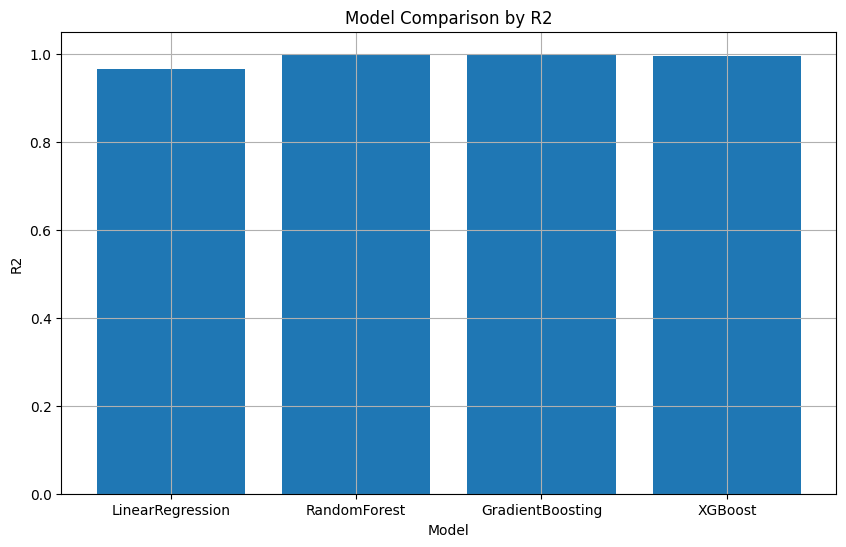

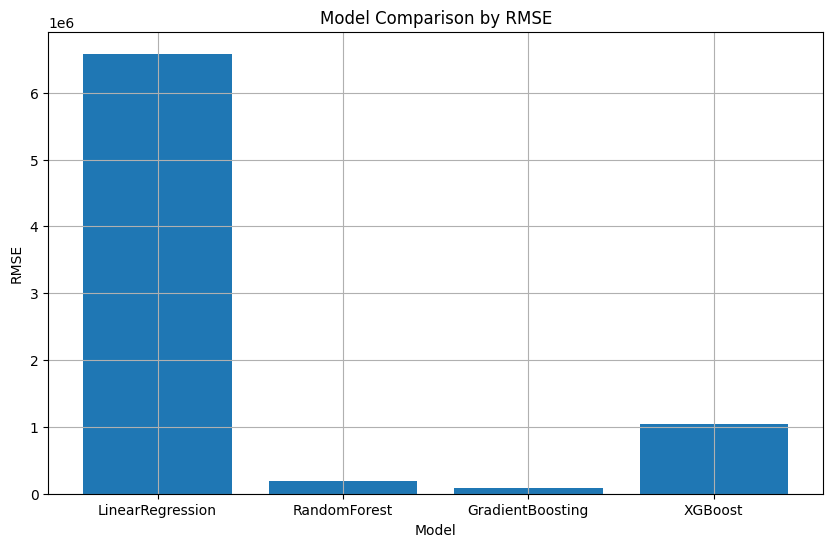

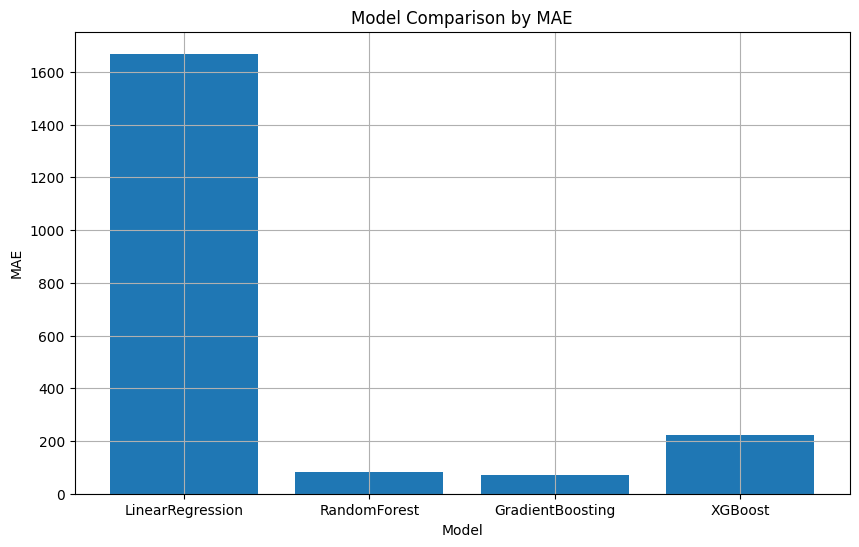

In [22]:
def plot_model_metrics(results, metric='r2'):
    names = list(results.keys())
    values = [results[name][metric] for name in names]

    plt.figure(figsize=(10, 6))
    plt.bar(names, values)
    plt.title(f'Model Comparison by {metric.upper()}')
    plt.xlabel('Model')
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.show()

# Example usage:
plot_model_metrics(results, metric='r2')
plot_model_metrics(results, metric='rmse')
plot_model_metrics(results, metric='mae')

In [23]:
import yaml

# Save model config with selected features 
# Display information about the best model
best_model_name = max(results, key=lambda x: results[x]['r2'])
best_model = results[best_model_name]['model']
best_params = best_model.get_params()
best_r2 = float(results[best_model_name]['r2'])
best_mae = float(results[best_model_name]['mae'])
best_rmse = float(results[best_model_name]['rmse'])

print(f"🏆 Best Model: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   MAE: {best_mae:.2f}")
print(f"   RMSE: {best_rmse:.2f}")

model_config = {
    'model': {
        'name': 'insurance_price_model',
        'best_model': best_model_name,
        'parameters': best_params,
        'r2_score': best_r2,
        'mae': best_mae,
        'target_variable': 'price',
    }
}

config_path = '../configs/model_config.yaml'
os.makedirs(os.path.dirname(config_path), exist_ok=True)
with open(config_path, 'w') as f:
    yaml.dump(model_config, f)

print(f"Saved model config to {config_path}")

🏆 Best Model: GradientBoosting
   R² Score: 0.9995
   MAE: 71.90
   RMSE: 84152.53
Saved model config to ../configs/model_config.yaml
